In [ ]:
# A Machine Learning Approach to Predicting Worker Performance Using Multiple Classification Models
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import requests
import io

# Download the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00597/garments_worker_productivity.csv"
response = requests.get(url)

# Load the dataset into a DataFrame
if response.status_code == 200:
    df = pd.read_csv(io.StringIO(response.text))
    print("Dataset loaded successfully!")
    print(df.head())  # Display the first few rows of the dataset
else:
    print(f"Failed to download the dataset. Status code: {response.status_code}")

Dataset loaded successfully!
       date   quarter  department       day  team  targeted_productivity  \
0  1/1/2015  Quarter1      sweing  Thursday     8                   0.80   
1  1/1/2015  Quarter1  finishing   Thursday     1                   0.75   
2  1/1/2015  Quarter1      sweing  Thursday    11                   0.80   
3  1/1/2015  Quarter1      sweing  Thursday    12                   0.80   
4  1/1/2015  Quarter1      sweing  Thursday     6                   0.80   

     smv     wip  over_time  incentive  idle_time  idle_men  \
0  26.16  1108.0       7080         98        0.0         0   
1   3.94     NaN        960          0        0.0         0   
2  11.41   968.0       3660         50        0.0         0   
3  11.41   968.0       3660         50        0.0         0   
4  25.90  1170.0       1920         50        0.0         0   

   no_of_style_change  no_of_workers  actual_productivity  
0                   0           59.0             0.940725  
1              

In [11]:
# Explore the dataset & looks like there are a lot of empty data on wip column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   float64
dtypes: f

In [12]:
# Strip unecessary extra spaces from values in the 'department' column
df['department'] = df['department'].str.strip()

# Replace NA value in WIP as 0 because it means they don't have WIP
df["wip"] = df["wip"].fillna(0)

# Remove rows where 'quarter' is 'Quarter5' since there shouldn't be 5th Quarter
df = df[df['quarter'] != 'Quarter5']

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1153 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1153 non-null   object 
 1   quarter                1153 non-null   object 
 2   department             1153 non-null   object 
 3   day                    1153 non-null   object 
 4   team                   1153 non-null   int64  
 5   targeted_productivity  1153 non-null   float64
 6   smv                    1153 non-null   float64
 7   wip                    1153 non-null   float64
 8   over_time              1153 non-null   int64  
 9   incentive              1153 non-null   int64  
 10  idle_time              1153 non-null   float64
 11  idle_men               1153 non-null   int64  
 12  no_of_style_change     1153 non-null   int64  
 13  no_of_workers          1153 non-null   float64
 14  actual_productivity    1153 non-null   float64
dtypes: float6

In [13]:
# Create target variable (achieve = 1 & not achieve = 0) based on Actual Productivity vs Targeted Productivity
df['achieve_target'] = df['actual_productivity'] > df['targeted_productivity']
df['achieve_target'] = df['achieve_target'].map({True: 1, False: 0})

# There seems to be imbalance in terms of target variable (with more labeled as 1) - will be taken as consideration at later stage
print(df["achieve_target"].value_counts())

achieve_target
1    832
0    321
Name: count, dtype: int64


In [14]:
# Define the features & target Column
X = df.drop(['team','date','achieve_target','actual_productivity','targeted_productivity'], axis=1)
y = df['achieve_target']

# Describe features
X.describe()

,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers
count,1153.000000,1153.000000,1153.000000,1153.000000,1153.000000,1153.000000,1153.000000,1153.000000
mean,15.102368,689.856028,4599.592368,38.402428,0.758023,0.383348,0.156114,34.722463
std,10.945789,1538.239883,3367.020281,163.014222,12.949387,3.330019,0.434912,22.160962
min,2.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,3.940000,0.000000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000
50%,15.260000,586.000000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000
75%,24.260000,1079.000000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000
max,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000


In [15]:
# Separate numerical and categorical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

print(numerical_features)
print(categorical_features)

Index(['smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men',
       'no_of_style_change', 'no_of_workers'],
      dtype='object')
Index(['quarter', 'department', 'day'], dtype='object')


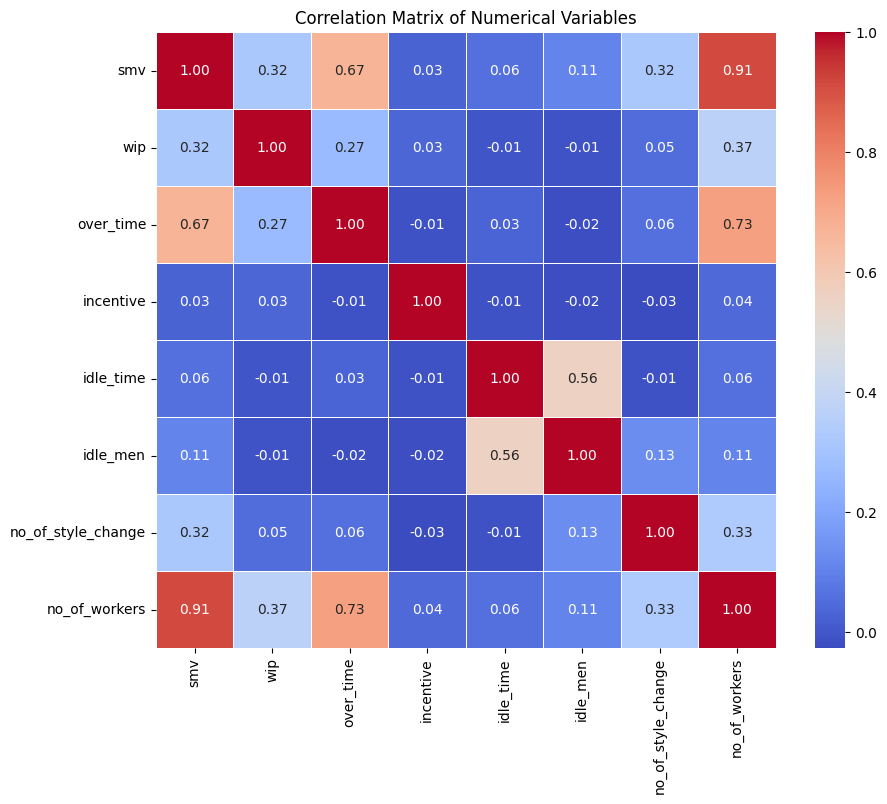

In [16]:
# Data Visualization - Correlation Matrix for Numerical Features
# Compute correlation matrix
corr_matrix = X[numerical_features].corr()

# Plot correlation matrix ~ it looks like smv, over_time and no_of_workers are correlated so we need to do features selection
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Variables")
plt.show()

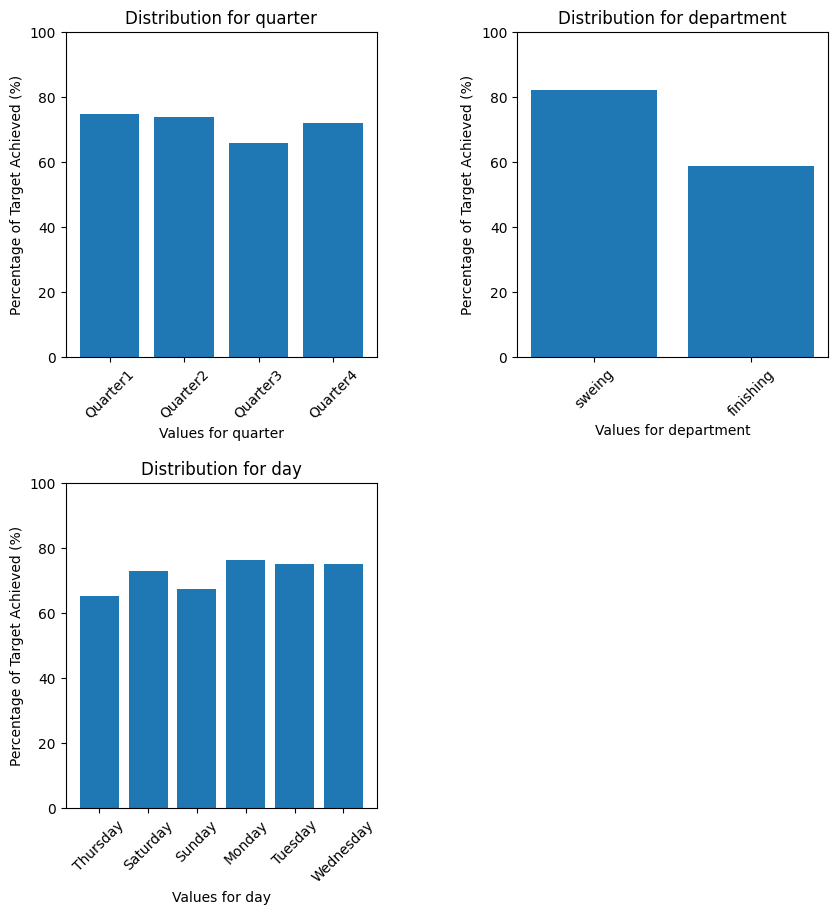

In [17]:
# Data Visualization - Histograms for Categorical Variables
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
# Add padding between subplots
fig.tight_layout(pad=7.0)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each categorical feature and plot in a subplot
for i, feature in enumerate(categorical_features):
    # Calculate percentage of target_achieved for each category
    cat_values = [val for val in df[feature].unique() if str(val) != 'nan']
    with_target = [len(df[(df[feature] == val) & (df['achieve_target'] == 1)]) / len(df[df[feature] == val]) for val in cat_values]
    with_target = [x * 100 for x in with_target]

    # Plot bar chart
    ax = axes[i]
    ax.bar([str(x) for x in cat_values], with_target)
    ax.set_ylim(0, 100)
    ax.set_xlabel(f"Values for {feature}")
    ax.set_ylabel('Percentage of Target Achieved (%)')
    ax.set_title(f"Distribution for {feature}")
    ax.tick_params(axis='x', rotation=45)

# If there are fewer than 4 features, hide the extra subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')  # Hide unused subplots

plt.show()

In [18]:
# Create Preprocessing Pipelines

# Impute missing numerical values with median & standard scaling
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Impute missing categorical values with most frequent & perform one hot encoding
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

In [21]:
# Use a simple train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, stratify=y, random_state=42)

In [22]:
# Define Models and Hyperparameter Grids
models = {
    "Logistic Regression": {
        "model": LogisticRegression(solver='lbfgs', max_iter=500, random_state=42),  # Default solver set to 'lbfgs'
        "params": {
            'classifier__C': np.logspace(-3, 3, 7),  # Regularization strength
            'classifier__penalty': ['l2']
        }
    },
    "Naive Bayes": {
        "model": GaussianNB(),
        "params": {}
    },
    "LDA": {
        "model": LinearDiscriminantAnalysis(solver='svd'),
        "params": {}
    },
    "QDA": {
        "model": QuadraticDiscriminantAnalysis(),
        "params": {
            'classifier__reg_param': [0.5, 0.75, 1.0]  # Regularization parameter for QDA set higher because there is colinearity between some numerical variables
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            'classifier__n_estimators': [50, 100, 200, 300],  # More trees
            'classifier__max_depth': [None, 10, 20, 30],  # Deeper trees
            'classifier__min_samples_split': [2, 5, 10],  # Added for controlling splits
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            'classifier__n_estimators': [50, 100, 200, 300],  # More boosting stages
            'classifier__learning_rate': [0.001, 0.01, 0.1, 1],  # Wider range for learning rate
            'classifier__max_depth': [3, 5, 7, 9]  # Deeper trees
        }
    },
    "SVM (Linear)": {
        "model": SVC(kernel='linear', random_state=42),
        "params": {
            'classifier__C': np.logspace(-3, 3, 7)  # Range for regularization
        }
    },
    "SVM (RBF)": {
        "model": SVC(kernel='rbf', random_state=42),
        "params": {
            'classifier__C': np.logspace(-3, 3, 7),  # Range for regularization
            'classifier__gamma': ['auto'] # Use auto because data will already be scaled prior to model fitting
        }
    },
    "SVM (Polynomial)": {
        "model": SVC(kernel='poly', random_state=42),
        "params": {
            'classifier__C': np.logspace(-3, 3, 7),  # Range for regularization
            'classifier__gamma': ['auto'],  # Use auto because data will already be scaled prior to model fitting
            'classifier__degree': [2, 3]  # Range for higher polynomial degrees
        }
    }
}

In [23]:
# Perform GridSearchCV with Stratified K-Fold on Training Data ~ it is a lot of models so take quite a long time

results = []
confusion_matrices = {}

for name, config in models.items():
    print(f"Running GridSearchCV for {name}...")
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', config["model"])
    ])

    # Stratified K-Fold for GridSearchCV (inner split)
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(pipeline, config["params"], cv=inner_cv, scoring='accuracy')
    grid_search.fit(X_train, y_train)


    # Evaluate on the test set
    y_pred = grid_search.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    # Store results
    results.append({
        "Model": name,
        "Test Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "ROC-AUC": roc_auc,
    })

    # Store confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices[name] = cm

Running GridSearchCV for Logistic Regression...
Running GridSearchCV for Naive Bayes...
Running GridSearchCV for LDA...
Running GridSearchCV for QDA...
Running GridSearchCV for Random Forest...
Running GridSearchCV for Gradient Boosting...
Running GridSearchCV for SVM (Linear)...
Running GridSearchCV for SVM (RBF)...
Running GridSearchCV for SVM (Polynomial)...



Confusion Matrix for Logistic Regression:


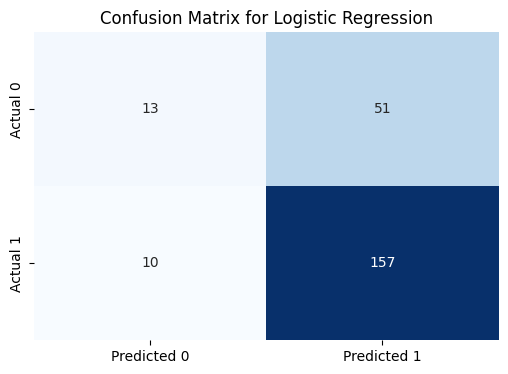


Confusion Matrix for Naive Bayes:


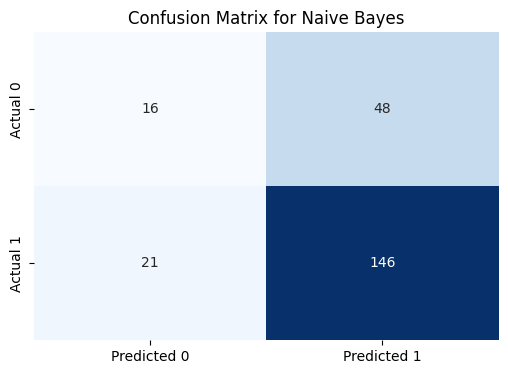


Confusion Matrix for LDA:


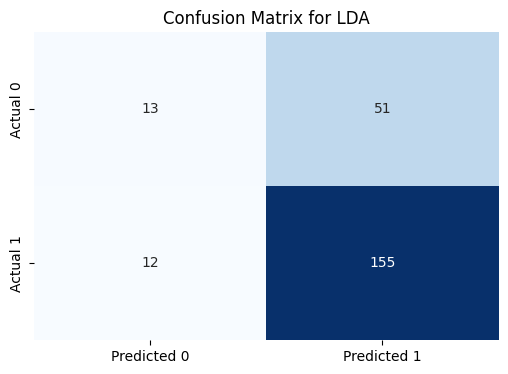


Confusion Matrix for QDA:


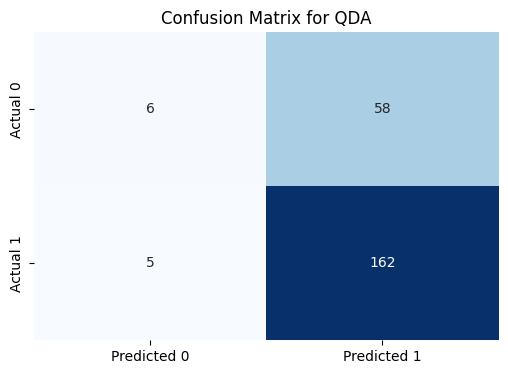


Confusion Matrix for Random Forest:


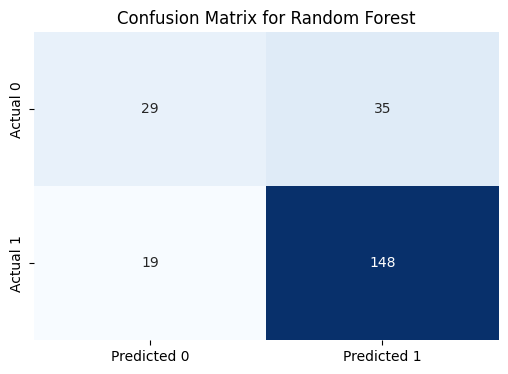


Confusion Matrix for Gradient Boosting:


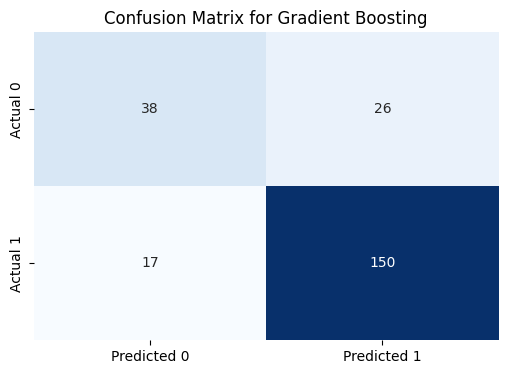


Confusion Matrix for SVM (Linear):


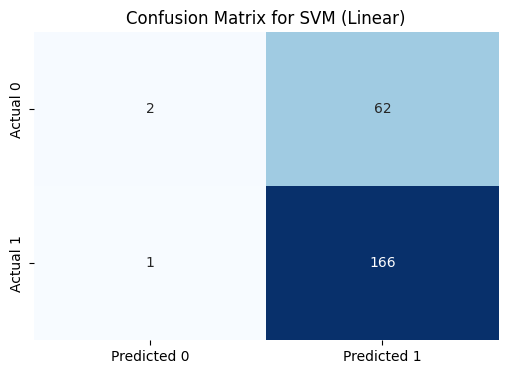


Confusion Matrix for SVM (RBF):


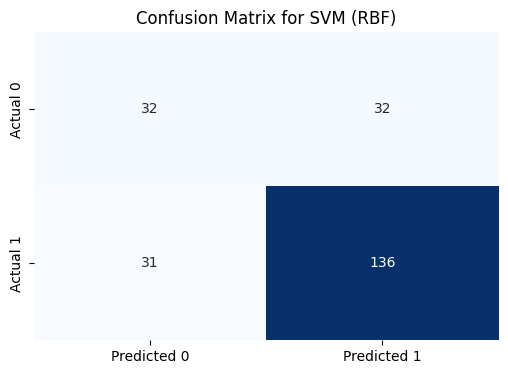


Confusion Matrix for SVM (Polynomial):


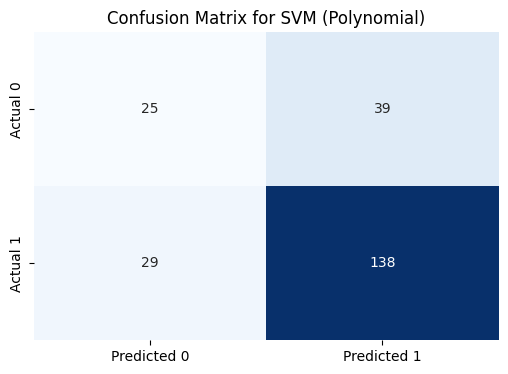

In [24]:
# Print and visualize confusion matrices for each model
for name, cm in confusion_matrices.items():
    print(f"\nConfusion Matrix for {name}:")

    # Visualize confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f"Confusion Matrix for {name}")
    plt.show()

In [25]:
# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results)
print(results_df)

#Gradient boosting seems to give the best model based on F1 Score ~0.9 - F1 measure is used since y value is imbalanced here

                 Model  Test Accuracy  Precision    Recall  F1 Score   ROC-AUC
0  Logistic Regression       0.735931   0.754808  0.940120  0.837333  0.571622
1          Naive Bayes       0.701299   0.752577  0.874251  0.808864  0.562126
2                  LDA       0.727273   0.752427  0.928144  0.831099  0.565634
3                  QDA       0.727273   0.736364  0.970060  0.837209  0.531905
4        Random Forest       0.766234   0.808743  0.886228  0.845714  0.669676
5    Gradient Boosting       0.813853   0.852273  0.898204  0.874636  0.745977
6         SVM (Linear)       0.727273   0.728070  0.994012  0.840506  0.512631
7            SVM (RBF)       0.727273   0.809524  0.814371  0.811940  0.657186
8     SVM (Polynomial)       0.705628   0.779661  0.826347  0.802326  0.608486
